In [1]:
import pandas as pd
import os
import os.path as op
import h5py
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from dtw import *
from mne.io import read_epochs_eeglab

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
pipeline='NEARICA_behav'
ages=['9m','12m','adult']

def load_bursts(pipeline, age):
    bursts = {
        'age': [],
        'subject': [],
        'chan': [],
        'cluster': [],
        'epoch': [],
        'fwhm_freq': [],
        'fwhm_time': [],
        'peak_adjustment': [],
        'peak_amp_base': [],
        'peak_amp_iter': [],
        'peak_freq': [],
        'peak_time': [],
        'polarity': [],
        'trial': [],
        'waveform': [],        
        'waveform_times': []
    }

    subjects=pd.read_csv(op.join('/home/bonaiuto/dev_beta_umd/data',age,'data/participants.tsv'), sep='\t')
    for subject in subjects['participant_id']:
        print('loading {}'.format(subject))
        fname=op.join('/home/bonaiuto/dev_beta_umd/data',age,'derivatives',pipeline,subject,'processed_data/processed_bursts.mat')
        if os.path.exists(fname):
            with h5py.File(fname, 'r') as f:
                bursts['age'].extend([age for x in list(f['bursts']['trial'])])
                bursts['subject'].extend([subject for x in list(f['bursts']['trial'])])
                bursts['chan'].extend(list(np.squeeze(f['bursts']['chan'][:])))
                bursts['cluster'].extend([u''.join(chr(c) for c in np.squeeze(f[obj_ref][:])) for obj_ref in np.squeeze(f['bursts']['cluster'][:])])
                bursts['epoch'].extend([u''.join(chr(c) for c in np.squeeze(f[obj_ref][:])) for obj_ref in np.squeeze(f['bursts']['epoch'][:])])
                bursts['fwhm_freq'].extend(list(np.squeeze(f['bursts']['fwhm_freq'][:])))
                bursts['fwhm_time'].extend(list(np.squeeze(f['bursts']['fwhm_time'][:])))
                bursts['peak_adjustment'].extend(list(np.squeeze(f['bursts']['peak_adjustment'][:])))
                bursts['peak_amp_base'].extend(list(np.squeeze(f['bursts']['peak_amp_base'][:])))
                bursts['peak_amp_iter'].extend(list(np.squeeze(f['bursts']['peak_amp_iter'][:])))
                bursts['peak_freq'].extend(list(np.squeeze(f['bursts']['peak_freq'][:])))
                bursts['peak_time'].extend(list(np.squeeze(f['bursts']['peak_time'][:])))
                bursts['polarity'].extend(list(np.squeeze(f['bursts']['polarity'][:])))
                bursts['trial'].extend(list(np.squeeze(f['bursts']['trial'][:])))
                for i in range(f['bursts']['waveform'][:,:].shape[1]):
                    bursts['waveform'].append(f['bursts']['waveform'][:,i])
                bursts['waveform_times']=f['bursts']['waveform_times'][:]
                
    bursts['age']=np.array(bursts['age'])
    bursts['subject']=np.array(bursts['subject'])
    bursts['chan']=np.array(bursts['chan'])
    bursts['cluster']=np.array(bursts['cluster'])
    bursts['epoch']=np.array(bursts['epoch'])
    bursts['fwhm_freq']=np.array(bursts['fwhm_freq'])
    bursts['fwhm_time']=np.array(bursts['fwhm_time'])
    bursts['peak_adjustment']=np.array(bursts['peak_adjustment'])
    bursts['peak_amp_base']=np.array(bursts['peak_amp_base'])
    bursts['peak_amp_iter']=np.array(bursts['peak_amp_iter'])
    bursts['peak_freq']=np.array(bursts['peak_freq'])
    bursts['peak_time']=np.array(bursts['peak_time'])
    bursts['polarity']=np.array(bursts['polarity'])
    bursts['trial']=np.array(bursts['trial'])
    bursts['waveform']=np.array(bursts['waveform'])
    bursts['waveform_times']=np.array(bursts['waveform_times'])
    
    return bursts

In [4]:
c_bursts_9m=load_bursts(pipeline, '9m')

loading sub-010
loading sub-012
loading sub-013
loading sub-014
loading sub-015
loading sub-016
loading sub-018
loading sub-019
loading sub-020
loading sub-021
loading sub-023
loading sub-024
loading sub-025
loading sub-026
loading sub-027
loading sub-028
loading sub-029
loading sub-030
loading sub-031
loading sub-032
loading sub-033
loading sub-036
loading sub-037
loading sub-038
loading sub-041
loading sub-042
loading sub-043
loading sub-044


In [5]:
c_bursts_12m=load_bursts(pipeline, '12m')

loading sub-001
loading sub-002
loading sub-003
loading sub-004
loading sub-005
loading sub-006
loading sub-007
loading sub-008
loading sub-009
loading sub-010
loading sub-011
loading sub-012
loading sub-013
loading sub-014
loading sub-015
loading sub-016
loading sub-017
loading sub-018
loading sub-019
loading sub-020
loading sub-021
loading sub-022
loading sub-023
loading sub-024
loading sub-025
loading sub-026
loading sub-027
loading sub-028
loading sub-029
loading sub-030
loading sub-031
loading sub-032
loading sub-033


In [6]:
c_bursts_adult=load_bursts(pipeline, 'adult')

loading sub-001
loading sub-002
loading sub-003
loading sub-004
loading sub-005
loading sub-006
loading sub-007
loading sub-008
loading sub-009
loading sub-010
loading sub-011
loading sub-012
loading sub-013
loading sub-014
loading sub-015
loading sub-016
loading sub-017
loading sub-018
loading sub-019
loading sub-020
loading sub-021
loading sub-022


In [8]:
c_burst_times_9m=c_bursts_9m['waveform_times']
c_burst_times_12m=c_bursts_12m['waveform_times']
c_burst_times_adult=c_bursts_adult['waveform_times']
med_c_9m=np.percentile(c_bursts_9m['waveform'], 50, axis=0)
med_c_12m=np.percentile(c_bursts_12m['waveform'], 50, axis=0)
med_c_adult=np.percentile(c_bursts_adult['waveform'], 50, axis=0)
norm_c_adult=med_c_adult/np.max(med_c_adult)
norm_c_12m=med_c_12m/np.max(med_c_12m)
norm_c_9m=med_c_9m/np.max(med_c_9m)
alignment_c_9m=dtw(norm_c_9m, norm_c_adult, keep_internals=True, step_pattern=rabinerJuangStepPattern(5,"c"))
aligned_c_9m_idx=warp(alignment_c_9m,index_reference=False)
alignment_c_12m=dtw(norm_c_12m, norm_c_adult, keep_internals=True, step_pattern=rabinerJuangStepPattern(5,"c"))
aligned_c_12m_idx=warp(alignment_c_12m,index_reference=False)
aligned_c_9m_bursts=c_bursts_9m['waveform'][:,aligned_c_9m_idx]
aligned_c_12m_bursts=c_bursts_12m['waveform'][:,aligned_c_12m_idx]
aligned_c_adult_bursts=c_bursts_adult['waveform'][:,:-1]

In [9]:
print('9m C: distance={}'.format(alignment_c_9m.normalizedDistance))
print('12m C: distance={}'.format(alignment_c_12m.normalizedDistance))

9m C: distance=0.02308308215508108
12m C: distance=0.032500699070450716


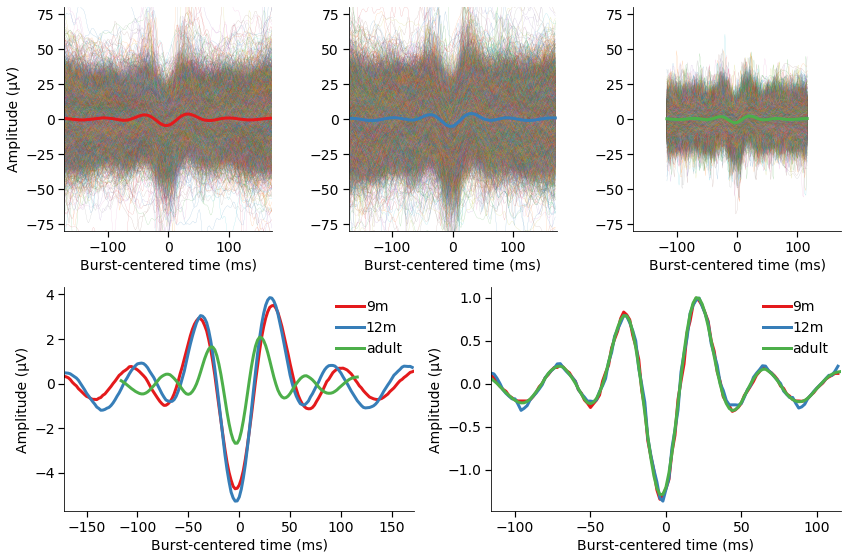

In [10]:
plt.rcParams.update({
    'font.size': 14,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})

nine_color=np.array([228,26,28])/255.0
twelve_color=np.array([55,126,184])/255.0
adult_color=np.array([77,175,74])/255.0

fig = plt.figure(figsize=(12,8), facecolor="white")
gs = fig.add_gridspec(2,len(ages)*2)

ylims=[-80,80]
ax = fig.add_subplot(gs[0, 0:2])
ax.plot(c_burst_times_9m, c_bursts_9m['waveform'].T, lw=0.2, alpha=0.5,rasterized=True)
ax.plot(c_burst_times_9m, np.percentile(c_bursts_9m['waveform'], 50, axis=0), lw=3, alpha=1, c=nine_color)
ax.set_ylim(ylims)
ax.set_xlim([c_burst_times_9m[0], c_burst_times_9m[-1]])
ax.set_xlabel('Burst-centered time (ms)')
ax.set_ylabel('Amplitude (µV)')
ax.spines[['top','right']].set_visible(False)

ax = fig.add_subplot(gs[0, 2:4])
ax.plot(c_burst_times_12m, c_bursts_12m['waveform'].T, lw=0.2, alpha=0.5,rasterized=True)
ax.plot(c_burst_times_12m, np.percentile(c_bursts_12m['waveform'], 50, axis=0), lw=3, alpha=1, c=twelve_color)
ax.set_ylim(ylims)
ax.set_xlim([c_burst_times_9m[0], c_burst_times_9m[-1]])
ax.set_xlabel('Burst-centered time (ms)')
ax.spines[['top','right']].set_visible(False)

ax = fig.add_subplot(gs[0, 4:6])
ax.plot(c_burst_times_adult, c_bursts_adult['waveform'].T, lw=0.2, alpha=0.5,rasterized=True)
ax.plot(c_burst_times_adult, np.percentile(c_bursts_adult['waveform'], 50, axis=0), lw=3, alpha=1, c=adult_color)
ax.set_ylim(ylims)
ax.set_xlim([c_burst_times_9m[0], c_burst_times_9m[-1]])
ax.set_xlabel('Burst-centered time (ms)')
ax.spines[['top','right']].set_visible(False)

ax = fig.add_subplot(gs[1, 0:3])
ax.plot(c_burst_times_9m, med_c_9m, lw=3, alpha=1, label='9m', color=nine_color)
ax.plot(c_burst_times_12m, med_c_12m, lw=3, alpha=1, label='12m', color=twelve_color)
ax.plot(c_burst_times_adult, med_c_adult, lw=3, alpha=1, label='adult', color=adult_color)
ax.set_xlim([c_burst_times_9m[0], c_burst_times_9m[-1]])
ax.set_xlabel('Burst-centered time (ms)')
ax.set_ylabel('Amplitude (µV)')
ax.spines[['top','right']].set_visible(False)
ax.legend()

ax = fig.add_subplot(gs[1, 3:6])
ax.plot(c_burst_times_adult[:-1], norm_c_9m[aligned_c_9m_idx], lw=3, alpha=1, label='9m', color=nine_color)
ax.plot(c_burst_times_adult[:-1], norm_c_12m[aligned_c_12m_idx], lw=3, alpha=1, label='12m', color=twelve_color)
ax.plot(c_burst_times_adult, norm_c_adult, lw=3, alpha=1, label='adult', color=adult_color)
ax.set_xlim([c_burst_times_adult[0], c_burst_times_adult[-1]])
ax.set_xlabel('Burst-centered time (ms)')
ax.set_ylabel('Amplitude (µV)')
ax.spines[['top','right']].set_visible(False)
ax.legend()

plt.tight_layout()
fig.savefig('/home/bonaiuto/dev_beta_umd/output/figures/figure4.svg')
fig.savefig('/home/bonaiuto/dev_beta_umd/output/figures/figure4.png')

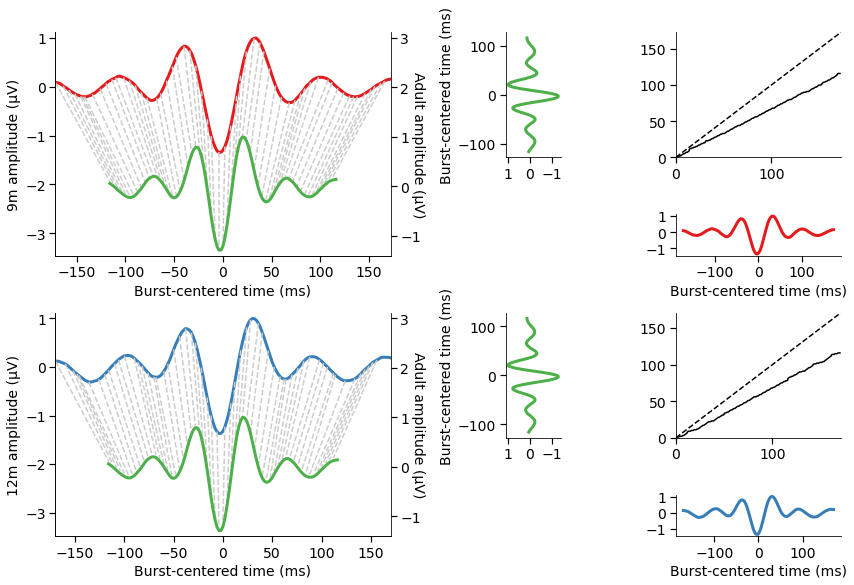

In [11]:
plt.rcParams.update({
    'font.size': 14,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})


fig=plt.figure(figsize=(12,8))
gs = fig.add_gridspec(4,4, width_ratios=[1,3,1,3], height_ratios=[3,1,3,1])

ax1 = fig.add_subplot(gs[0:2, 0:2])
ax2 = ax1.twinx()
ax1.plot(c_burst_times_9m,norm_c_9m,linewidth=3,color=nine_color)
ax2.plot(c_burst_times_adult,norm_c_adult,linewidth=3,color=adult_color)
yl1=ax1.get_ylim()
ax1.set_ylim([yl1[0]-2, yl1[1]])
yl2=ax2.get_ylim()
ax2.set_ylim([yl2[0], yl2[1]+2])
for adult_idx in range(len(aligned_c_9m_idx)):
    if adult_idx % 2 == 0:
        inf_idx=aligned_c_9m_idx[adult_idx]
        ax1.plot([c_burst_times_9m[inf_idx], c_burst_times_adult[adult_idx]], 
                 [norm_c_9m[inf_idx], norm_c_adult[adult_idx]-2],'--', color='0.8')
ax1.set_xlim(c_burst_times_9m[[0,-1]])
ax1.set_xlabel('Burst-centered time (ms)')
ax1.set_ylabel('9m amplitude (µV)')
ax2.set_ylabel('Adult amplitude (µV)', rotation=270)
ax2.spines[['right']].set_visible(True)

axr = fig.add_subplot(gs[0,2])
ax = plt.subplot(gs[0,3])
axq = plt.subplot(gs[1,3])
axq.plot(c_burst_times_9m, norm_c_9m,linewidth=3,color=nine_color)
axq.set_xlabel('Burst-centered time (ms)')
axr.plot(norm_c_adult,c_burst_times_adult, linewidth=3,color=adult_color)
axr.invert_xaxis()
axr.set_ylabel('Burst-centered time (ms)')
ax.plot(alignment_c_9m.index1, alignment_c_9m.index2,'k')
max_idx=np.max([len(c_burst_times_9m), len(c_burst_times_adult)])
ax.plot([0,max_idx],[0,max_idx],'k--')
ax.set_xlim([0, max_idx])
ax.set_ylim([0, max_idx])

ax1 = fig.add_subplot(gs[2:4, 0:2])
ax2 = ax1.twinx()
ax1.plot(c_burst_times_12m,norm_c_12m,linewidth=3,color=twelve_color)
ax2.plot(c_burst_times_adult,norm_c_adult,linewidth=3,color=adult_color)
yl1=ax1.get_ylim()
ax1.set_ylim([yl1[0]-2, yl1[1]])
yl2=ax2.get_ylim()
ax2.set_ylim([yl2[0], yl2[1]+2])
for adult_idx in range(len(aligned_c_12m_idx)):
    if adult_idx % 2 == 0:
        inf_idx=aligned_c_12m_idx[adult_idx]
        ax1.plot([c_burst_times_12m[inf_idx], c_burst_times_adult[adult_idx]], 
                 [norm_c_12m[inf_idx], norm_c_adult[adult_idx]-2],'--', color='0.8')
ax1.set_xlim(c_burst_times_12m[[0,-1]])
ax1.set_xlabel('Burst-centered time (ms)')
ax1.set_ylabel('12m amplitude (µV)')
ax2.set_ylabel('Adult amplitude (µV)', rotation=270)
ax2.spines[['right']].set_visible(True)


axr = fig.add_subplot(gs[2,2])
ax = plt.subplot(gs[2,3])
axq = plt.subplot(gs[3,3])
axq.plot(c_burst_times_12m, norm_c_12m,linewidth=3,color=twelve_color)
axq.set_xlabel('Burst-centered time (ms)')
axr.plot(norm_c_adult,c_burst_times_adult, linewidth=3,color=adult_color)
axr.invert_xaxis()
axr.set_ylabel('Burst-centered time (ms)')
ax.plot(alignment_c_12m.index1, alignment_c_12m.index2,'k')
max_idx=np.max([len(c_burst_times_12m), len(c_burst_times_adult)])
ax.plot([0,max_idx],[0,max_idx],'k--')
ax.set_xlim([0, max_idx])
ax.set_ylim([0, max_idx])

plt.tight_layout()

plt.savefig('/home/bonaiuto/dev_beta_umd/output/figures/figure_s4.svg')
plt.savefig('/home/bonaiuto/dev_beta_umd/output/figures/figure_s4.png')